# Hi :)

----

In [14]:
import cv2
import numpy as np
from moviepy.video.VideoClip import VideoClip
from PIL import Image, ImageDraw

def image_to_video(image_path, output_video_path, scale_factor, duration):
    def detect_and_scale(image_path, scale_factor):
        # Load the image
        image= cv2.imread(image_path)
        gray= cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        # Detect the black dot
        _, binary_dot= cv2.threshold(gray, 30, 255, cv2.THRESH_BINARY_INV)
        contours_dot, _= cv2.findContours(binary_dot, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
        detected_dot= None
        for contour in contours_dot:
            area= cv2.contourArea(contour)
            if 10 < area < 500:  # Filter small regions
                M= cv2.moments(contour)
                if M["m00"] != 0:
                    cx= int(M["m10"] / M["m00"])
                    cy= int(M["m01"] / M["m00"])
                    detected_dot= (cx, cy)
                    break
        # Detect the outer edge
        _, binary_edge= cv2.threshold(gray, 200, 255, cv2.THRESH_BINARY_INV)
        contours_edge, hierarchy= cv2.findContours(binary_edge, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
        outer_edge= None
        for i, contour in enumerate(contours_edge):
            if hierarchy[0][i][3] == -1:  # Outer edge has no parent
                outer_edge= contour
                break
        # Scale the outer edge
        scaled_outer_edge= []
        if outer_edge is not None:
            M= cv2.moments(outer_edge)
            cx= int(M["m10"] / M["m00"]) if M["m00"] != 0 else 0
            cy= int(M["m01"] / M["m00"]) if M["m00"] != 0 else 0
            center= np.array([cx, cy])
            for point in outer_edge:
                vector_to_center= point[0] - center
                scaled_point= center + vector_to_center * scale_factor
                scaled_outer_edge.append(scaled_point.astype(np.int32))
            scaled_outer_edge= np.array(scaled_outer_edge, dtype= np.int32)
        return scaled_outer_edge, detected_dot
    def animate_sequential_lines(image_path, output_path, scaled_path, duration):
        image= Image.open(image_path).convert("RGB")
        base_frame= np.array(image)
        def make_frame(t):
            frame= base_frame.copy()
            img= Image.fromarray(frame)
            draw= ImageDraw.Draw(img)
            time_per_line= duration / len(scaled_path)
            for i, point in enumerate(scaled_path[ : -1]):
                start_point= point
                end_point= scaled_path[i + 1]
                line_start_time= i * time_per_line
                line_end_time= (i + 1) * time_per_line
                if line_start_time <= t < line_end_time:
                    progress= (t - line_start_time) / time_per_line
                    x1, y1= start_point
                    x2, y2= end_point
                    current_x= int(x1 + (x2 - x1) * progress)
                    current_y= int(y1 + (y2 - y1) * progress)
                    draw.line((x1, y1, current_x, current_y), fill= "red", width= 4)
                elif t >= line_end_time:
                    x1, y1= start_point
                    x2, y2= end_point
                    draw.line((x1, y1, x2, y2), fill= "red", width= 5)
            return np.array(img)
        animation= VideoClip(make_frame, duration= duration)
        animation.write_videofile(output_path, fps= 24)
    # Detect and scale
    scaled_path, detected_dot= detect_and_scale(image_path, scale_factor)
    if detected_dot is None or len(scaled_path) == 0:
        raise ValueError("Failed to detect required features in the image.")
    # Transform the scaled path
    target= np.array([detected_dot[0], detected_dot[1]])
    distances= np.linalg.norm(scaled_path - target, axis= 1)
    closest_idx= np.argmin(distances)
    before_closest= scaled_path[:closest_idx]
    after_closest= scaled_path[closest_idx + 1:]
    result= np.vstack((scaled_path[closest_idx : closest_idx + 1], np.flip(before_closest, axis= 0), np.flip(after_closest, axis= 0)))    
    # Cut and append elements
    n= 4
    if len(result) > n:
        first_n= result[:n]
        remaining= result[n:]
        result= np.vstack((remaining, first_n))
    # Animate the lines
    animate_sequential_lines(image_path, output_video_path, result, duration)

# # Example usage
# input_image= "Circle.jpg"  # Replace with the path to your image
# output_video= "output_animation.mp4"
# image_to_video(input_image, output_video, scale_factor= 0.87, duration= 4)

In [15]:
input_image= "M.jpg"  # Replace with the path to your image
output_video= "M.mp4"
image_to_video(input_image, output_video, scale_factor= 1, duration= 4)

MoviePy - Building video M.mp4.
MoviePy - Writing video M.mp4



MoviePy - Done !
MoviePy - video ready M.mp4


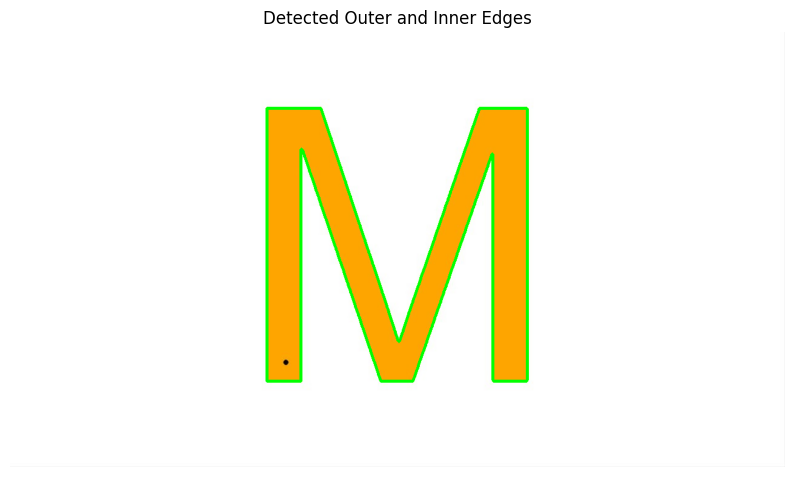

Outer edge detected.
Inner edge not detected.


In [16]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def detect_edges(image_path):
    # Load the image
    image= cv2.imread(image_path)
    gray= cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    
    # Apply a binary threshold to segment the orange pattern
    _, binary= cv2.threshold(gray, 200, 255, cv2.THRESH_BINARY_INV)  # Adjust threshold to segment orange
    
    # Find contours
    contours, hierarchy= cv2.findContours(binary, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    
    output_image= image.copy()
    edges= {"outer_edge": None, "inner_edge": None}

    for i, contour in enumerate(contours):
        area= cv2.contourArea(contour)
        if area > 1000:  # Filter out smaller areas
            # Determine if it's the outer or inner edge based on hierarchy
            if hierarchy[0][i][3] == -1:  # Outer edge has no parent
                edges["outer_edge"]= contour
                cv2.drawContours(output_image, [contour], -1, (0, 255, 0), 3)  # Green for outer edge
            else:  # Inner edge has a parent
                edges["inner_edge"]= contour
                cv2.drawContours(output_image, [contour], -1, (255, 0, 0), 3)  # Blue for inner edge

    # Show the processed image with detected edges
    plt.figure(figsize= (10, 6))
    plt.imshow(cv2.cvtColor(output_image, cv2.COLOR_BGR2RGB))
    plt.title("Detected Outer and Inner Edges")
    plt.axis("off")
    plt.show()
    
    return edges

# Provide the path to your image
image_path= "M.jpg"
edges= detect_edges(image_path)

if edges["outer_edge"] is not None:
    print("Outer edge detected.")
else:
    print("Outer edge not detected.")
    
if edges["inner_edge"] is not None:
    print("Inner edge detected.")
else:
    print("Inner edge not detected.")

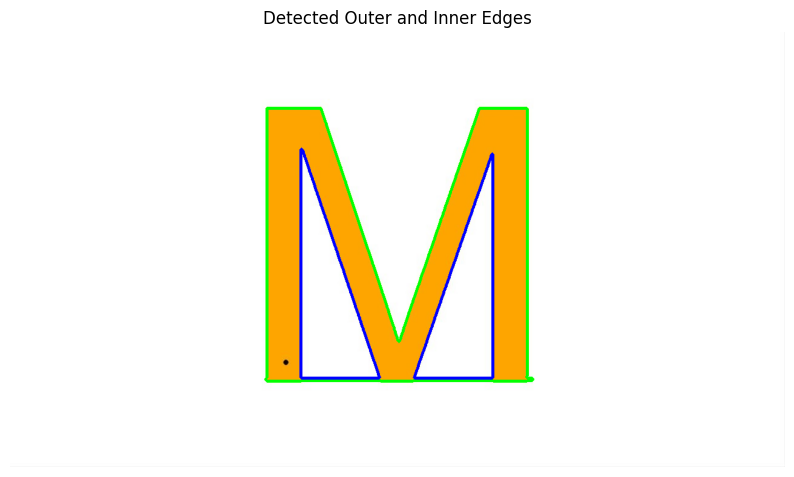

Outer edge detected.
Inner edge detected.


In [55]:

import cv2
import numpy as np
import matplotlib.pyplot as plt

def detect_edges(image_path):
    # Load the image
    image= cv2.imread(image_path)
    gray= cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    
    # Apply a binary threshold to segment the orange pattern
    _, binary= cv2.threshold(gray, 200, 255, cv2.THRESH_BINARY_INV)  # Adjust threshold to segment orange
    
    # Find contours
    contours, hierarchy= cv2.findContours(binary, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    
    output_image= image.copy()
    edges= {"outer_edge": None, "inner_edge": None}

    for i, contour in enumerate(contours):
        area= cv2.contourArea(contour)
        if area > 1000:  # Filter out smaller areas
            # Determine if it's the outer or inner edge based on hierarchy
            if hierarchy[0][i][3] == -1:  # Outer edge has no parent
                edges["outer_edge"]= contour
                cv2.drawContours(output_image, [contour], -1, (0, 255, 0), 3)  # Green for outer edge
            else:  # Inner edge has a parent
                edges["inner_edge"]= contour
                cv2.drawContours(output_image, [contour], -1, (255, 0, 0), 3)  # Blue for inner edge

    # Show the processed image with detected edges
    plt.figure(figsize= (10, 6))
    plt.imshow(cv2.cvtColor(output_image, cv2.COLOR_BGR2RGB))
    plt.title("Detected Outer and Inner Edges")
    plt.axis("off")
    plt.show()
    
    return edges

# Provide the path to your image
image_path= "M-Helper.jpg"
edges= detect_edges(image_path)

if edges["outer_edge"] is not None:
    print("Outer edge detected.")
else:
    print("Outer edge not detected.")
    
if edges["inner_edge"] is not None:
    print("Inner edge detected.")
else:
    print("Inner edge not detected.")

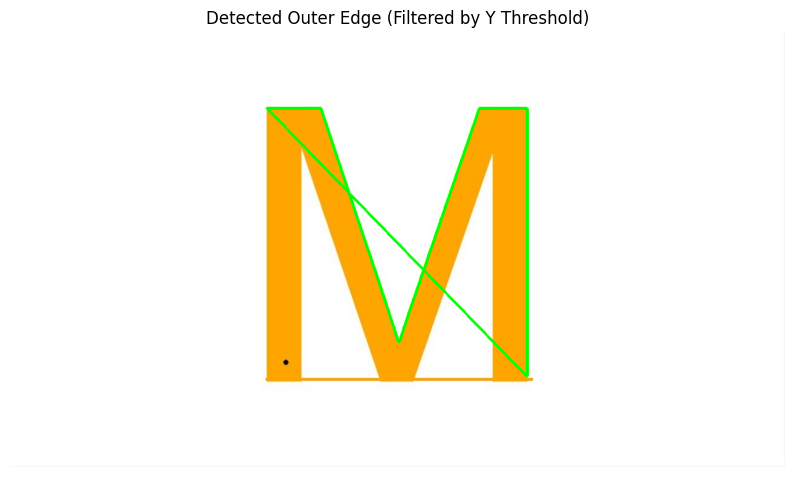

Filtered outer edge detected.


In [56]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def detect_outer_edge(image_path):
    # Load the image
    image = cv2.imread(image_path)
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    
    # Apply a binary threshold to segment the pattern
    _, binary = cv2.threshold(gray, 200, 255, cv2.THRESH_BINARY_INV)  # Adjust threshold as needed
    
    # Find contours
    contours, hierarchy = cv2.findContours(binary, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    
    output_image = image.copy()
    outer_edge = None

    for i, contour in enumerate(contours):
        area = cv2.contourArea(contour)
        if area > 1000:  # Filter out smaller areas
            # Check if it's the outer edge based on hierarchy
            if hierarchy[0][i][3] == -1:  # Outer edge has no parent
                # Calculate minimum y in the contour
                min_y = min(point[0][1] for point in contour)
                y_threshold = 571
                
                # Keep only points with y less than (min_y - 10)
                filtered_contour = np.array([point for point in contour if point[0][1] < y_threshold])
                
                if filtered_contour.size > 0:  # Ensure there are points remaining after filtering
                    outer_edge = filtered_contour
                    cv2.drawContours(output_image, [filtered_contour], -1, (0, 255, 0), 3)  # Green for outer edge

    # Show the processed image with the filtered outer edge
    plt.figure(figsize=(10, 6))
    plt.imshow(cv2.cvtColor(output_image, cv2.COLOR_BGR2RGB))
    plt.title("Detected Outer Edge (Filtered by Y Threshold)")
    plt.axis("off")
    plt.show()
    
    return outer_edge

# Provide the path to your image
image_path = "M-Helper.jpg"
outer_edge = detect_outer_edge(image_path)

if outer_edge is not None:
    print("Filtered outer edge detected.")
else:
    print("Outer edge not detected.")


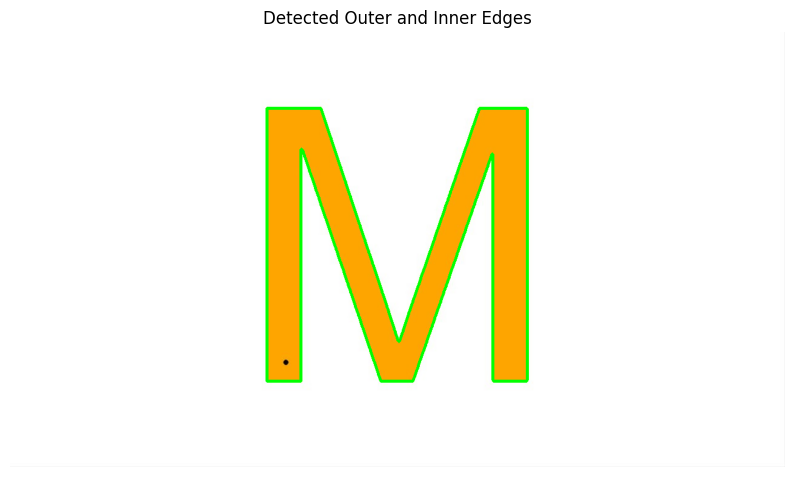

Filtered points detected:
[]


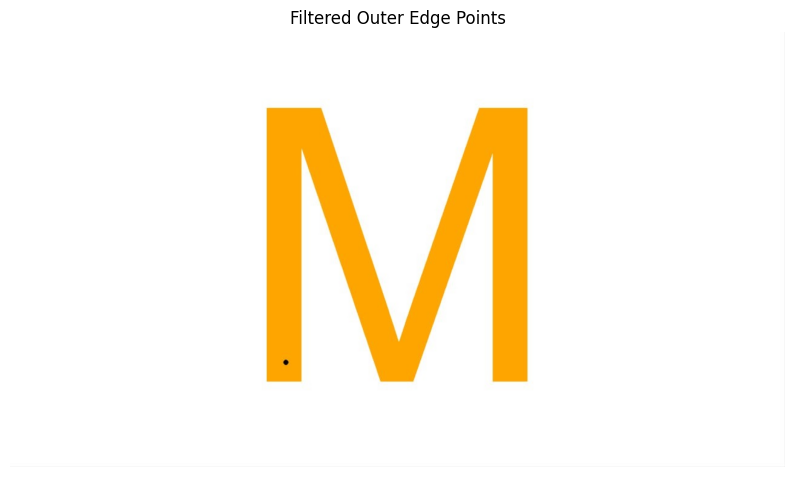

In [57]:

import cv2
import numpy as np
import matplotlib.pyplot as plt

def detect_edges(image_path):
    # Load the image
    image = cv2.imread(image_path)
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    
    # Apply a binary threshold to segment the orange pattern
    _, binary = cv2.threshold(gray, 200, 255, cv2.THRESH_BINARY_INV)  # Adjust threshold to segment orange
    
    # Find contours
    contours, hierarchy = cv2.findContours(binary, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    
    output_image = image.copy()
    edges = {"outer_edge": None, "inner_edge": None}

    for i, contour in enumerate(contours):
        area = cv2.contourArea(contour)
        if area > 1000:  # Filter out smaller areas
            # Determine if it's the outer or inner edge based on hierarchy
            if hierarchy[0][i][3] == -1:  # Outer edge has no parent
                edges["outer_edge"] = contour
                cv2.drawContours(output_image, [contour], -1, (0, 255, 0), 3)  # Green for outer edge
            else:  # Inner edge has a parent
                edges["inner_edge"] = contour
                cv2.drawContours(output_image, [contour], -1, (255, 0, 0), 3)  # Blue for inner edge

    # Show the processed image with detected edges
    plt.figure(figsize=(10, 6))
    plt.imshow(cv2.cvtColor(output_image, cv2.COLOR_BGR2RGB))
    plt.title("Detected Outer and Inner Edges")
    plt.axis("off")
    plt.show()
    
    return edges, image.shape

def filter_outer_edge(edges, image_shape):
    outer_edge = edges["outer_edge"]
    if outer_edge is None:
        print("No outer edge detected.")
        return None
    
    height, width, _ = image_shape
    proximity_threshold = 50  # Define a threshold to consider points close to the edges
    
    filtered_points = []
    for point in outer_edge:
        x, y = point[0]  # Get x and y coordinates
        # Keep points near the left, right, or top edges
        if x < proximity_threshold or x > width - proximity_threshold or y < proximity_threshold:
            filtered_points.append([x, y])
    
    return np.array(filtered_points)

def visualize_filtered_points(image_path, filtered_points):
    image = cv2.imread(image_path)
    for point in filtered_points:
        cv2.circle(image, tuple(point), 3, (0, 0, 255), -1)  # Draw red points
    
    plt.figure(figsize=(10, 6))
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.title("Filtered Outer Edge Points")
    plt.axis("off")
    plt.show()

# Provide the path to your image
image_path = "M.jpg"
edges, image_shape = detect_edges(image_path)
filtered_points = filter_outer_edge(edges, image_shape)

if filtered_points is not None:
    print("Filtered points detected:")
    print(filtered_points)
    visualize_filtered_points(image_path, filtered_points)
else:
    print("No filtered points to display.")
